In [18]:
import os, sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import contextily as cx
import seaborn as sns
import pickle

import IR_processing_utils

from tqdm import tqdm

import scipy.signal

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 7





In [19]:
data_dir = r'G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\DJI_202404210937_006_Pleystocen-IR'; flight_height = 160
#data_dir = r'M:\202404 Pleistocene Park\IR_mavic3\DJI_202404211121_009_Pleystocen-IRb'; flight_height = 160
#data_dir = r'M:\202404 Pleistocene Park\IR_mavic3\DJI_202404221002_011_Pleystocen-IR3'; flight_height = 220
#data_dir = r'M:\202404 Pleistocene Park\IR_mavic3\DJI_202404221218_016_Pleystocen-IR3b'; flight_height = 220
#data_dir = r'M:\202404 Pleistocene Park\IR_mavic3\DJI_202404230843_017_Pleystocen-IR5'; flight_height = 230

#data_dir = r'G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\DJI_202404231239_024_Pleystocen-IR3'; flight_height = 220




sensor_size = [6.144, 7.68] #Mavic sensor size in mm



corr_opts = {'detrend': True, 'L2_wnd': 9, 'L3_wnd':9}



img_array={}

img_array['raw'], img_df = IR_processing_utils.read_IR_images (data_dir, n_jobs = 4)

gps_az = np.zeros_like (img_df.gps_lon)
for i in range (0, img_df.shape[0]-1):
    gps_az[i] = IR_processing_utils.calc_compass_bearing ((img_df.gps_lat[i],img_df.gps_lon[i]), (img_df.gps_lat[i+1],img_df.gps_lon[i+1]))
gps_az[-1] = gps_az[-2]
img_df['gps_azimuth'] = gps_az

img_shape = img_array['raw'].shape
img_N = img_df.shape[0]


img_df = IR_processing_utils.init_polygons (img_df, sensor_size, flight_height)

display(img_df.head())

pics_dir = data_dir + '/processing_pics/'
if not os.path.isdir (pics_dir):
    os.mkdir (pics_dir)


file    gps_lat     gps_lon  Image ImageWidth  \
0  DJI_20240421094234_0001_T.tiff  68.512832  161.490580             640.0   
1  DJI_20240421094237_0002_T.tiff  68.512799  161.490781             640.0   
2  DJI_20240421094240_0003_T.tiff  68.512707  161.491339             640.0   
3  DJI_20240421094242_0004_T.tiff  68.512590  161.492057             640.0   
4  DJI_20240421094245_0005_T.tiff  68.512472  161.492785             640.0   

   Image ImageLength  Image BitsPerSample  Image Compression  \
0              512.0                 32.0                1.0   
1              512.0                 32.0                1.0   
2              512.0                 32.0                1.0   
3              512.0                 32.0                1.0   
4              512.0                 32.0                1.0   

   Image PhotometricInterpretation Image ImageDescription Image Make  ...  \
0                              1.0                IronRed        DJI  ...   
1                              1.0                IronRed        DJI  ...   
2                              1.0                IronRed        DJI  ...   
3                              1.0                IronRed        DJI  ...   
4                              1.0                IronRed        DJI  ...   

  EXIF BodySerialNumber  EXIF LensSpecification  gps_azimuth     min_lon  \
0                   1.0                     9.1   114.247083  161.488929   
1                   1.0                     9.1   114.145838  161.489130   
2                   1.0                     9.1   114.009953  161.489688   
3                   1.0                     9.1   113.824269  161.490406   
4                   1.0                     9.1   114.063282  161.491134   

      max_lon    min_lat    max_lat  delta_lon  delta_lat  \
0  161.492231  68.512348  68.513316   0.003302   0.000968   
1  161.492432  68.512315  68.513283   0.003302   0.000968   
2  161.492990  68.512223  68.513192   0.003302   0.000968   
3  161.493708  68.512106  68.513074   0.003302   0.000968   
4  161.494436  68.511988  68.512957   0.003302   0.000968   

                                             Polygon  
0  POLYGON ((161.49223109406037 68.51331631316418...  
1  POLYGON ((161.49243161941854 68.51328322983278...  
2  POLYGON ((161.49299019604356 68.51319150761593...  
3  POLYGON ((161.4937079374785 68.51307439651168,...  
4  POLYGON ((161.4944359288668 68.51295664651859,...  

[5 rows x 74 columns]

C:\Users\mvar9\AppData\Local\Temp\ipykernel_40816\3090313530.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(*pol.exterior.xy, '-k', color = 'gray')


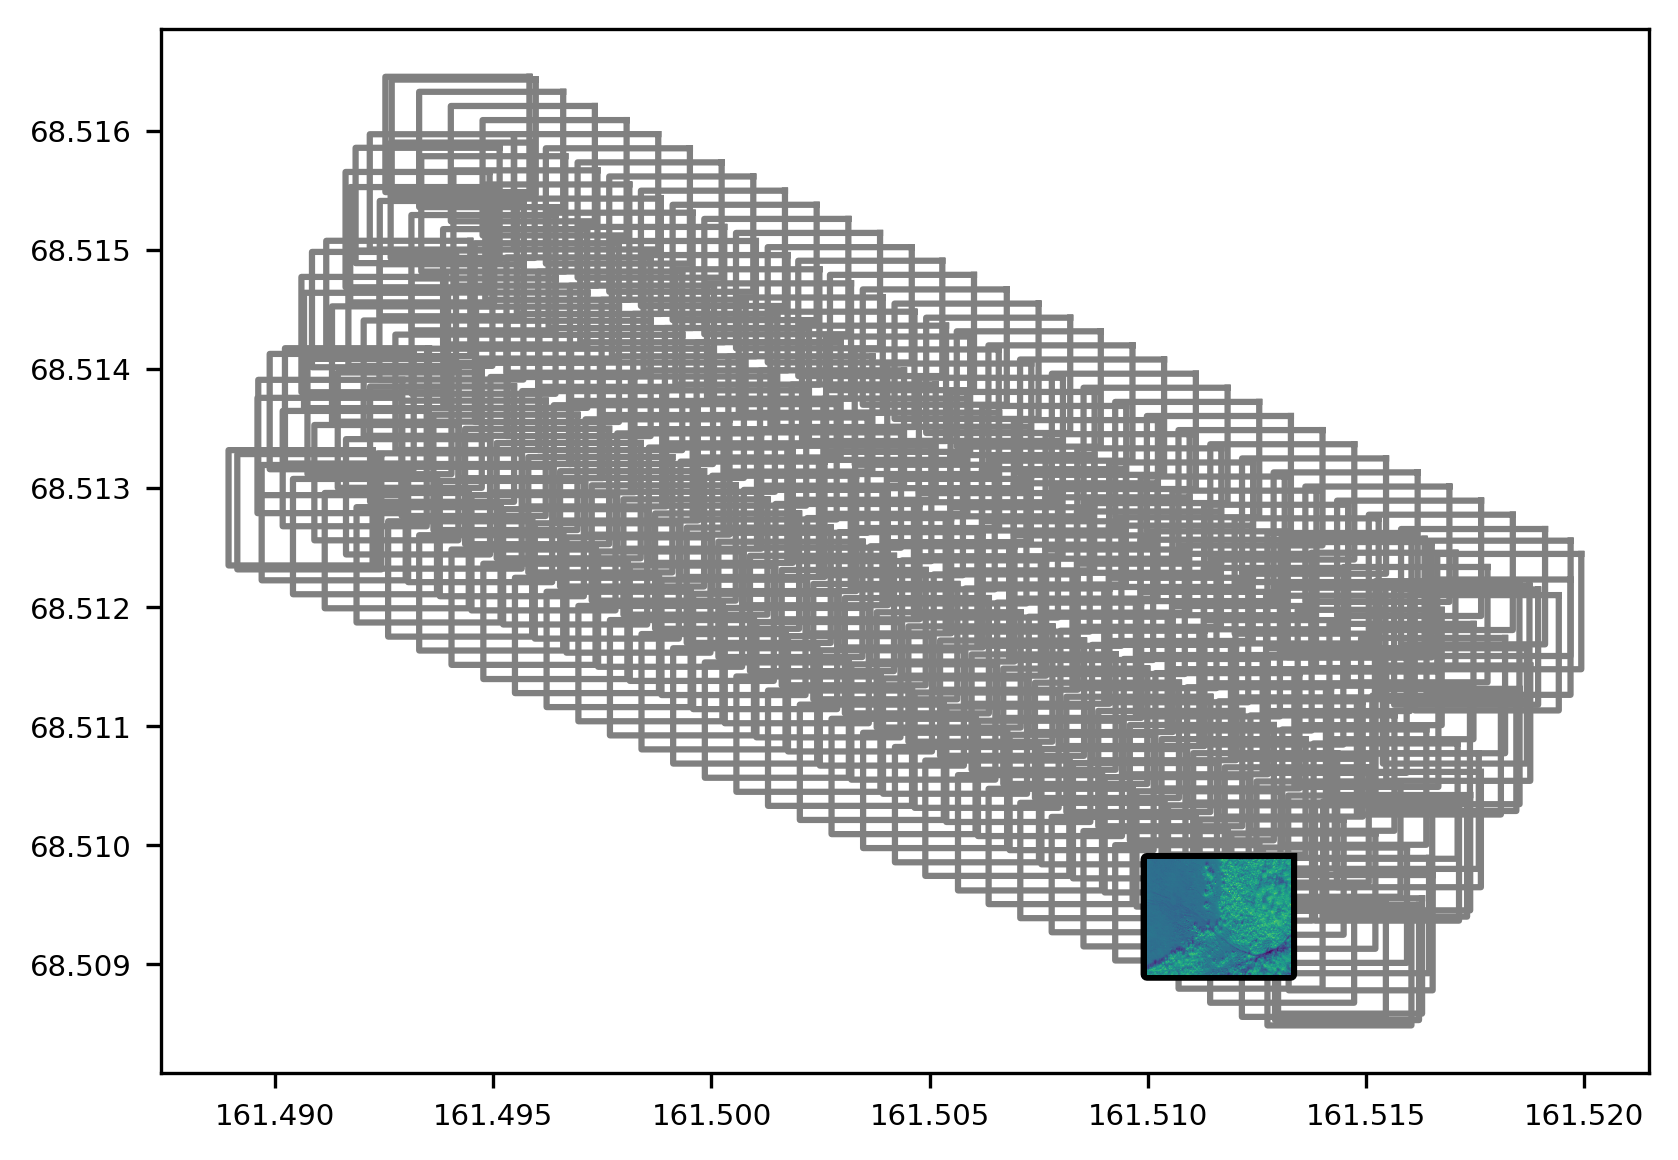

In [20]:
save_dir = pics_dir + '/preview/'
if not os.path.isdir (save_dir):
    os.mkdir (save_dir)

plt.figure()

for i, idx in enumerate(img_df.index):
    if i < 10 or i > 30: continue

    plt.clf()
    for pol in img_df['Polygon']:
        plt.plot(*pol.exterior.xy, '-k', color = 'gray')

    plt_x_lim = plt.xlim()
    plt_y_lim = plt.ylim()

    pol = img_df['Polygon'][idx]

    plt.plot(*pol.exterior.xy, '-k', linewidth = 3)

    x_mesh, y_mesh, _ = IR_processing_utils.create_mesh (img_df['min_lon'][idx], img_df['max_lon'][idx],
                                                         img_df['min_lat'][idx], img_df['max_lat'][idx], img_shape)

    
    plt.pcolormesh (x_mesh, y_mesh, img_array['raw'][:,:,i], zorder = 100) #, alpha=0.5)

    plt.xlim(plt_x_lim)
    plt.ylim(plt_y_lim)
    #cx.add_basemap(plt.gca(), source = cx.providers.Esri.WorldImagery, crs = 4326)            
    plt.gca().set_aspect(1.0/np.cos(np.array(plt.ylim()).mean()*np.pi/180))
    
    plt.savefig(save_dir + str(i)+'.png')
    
    

    

In [21]:
diff_matrix = {}

reload_pkl = False
pkl_path = data_dir + '/corr_matrix, h = %d'%flight_height + '.pkl'

if not os.path.isfile (pkl_path):
    reload_pkl = True
if reload_pkl:
    diff_matrix['raw'], diff_weights = IR_processing_utils.calc_diff_matrix (img_array['raw'], img_df)

    with open(pkl_path, 'wb') as handle:
        pickle.dump((diff_matrix['raw'], diff_weights), handle, protocol=pickle.HIGHEST_PROTOCOL) 
else:
    with open(pkl_path, 'rb') as handle:
        diff_matrix['raw'], diff_weights = pickle.load(handle)




'n_outliers = 7, max_diff = 3.678656'

'n_outliers = 1, max_diff = 1.362779'

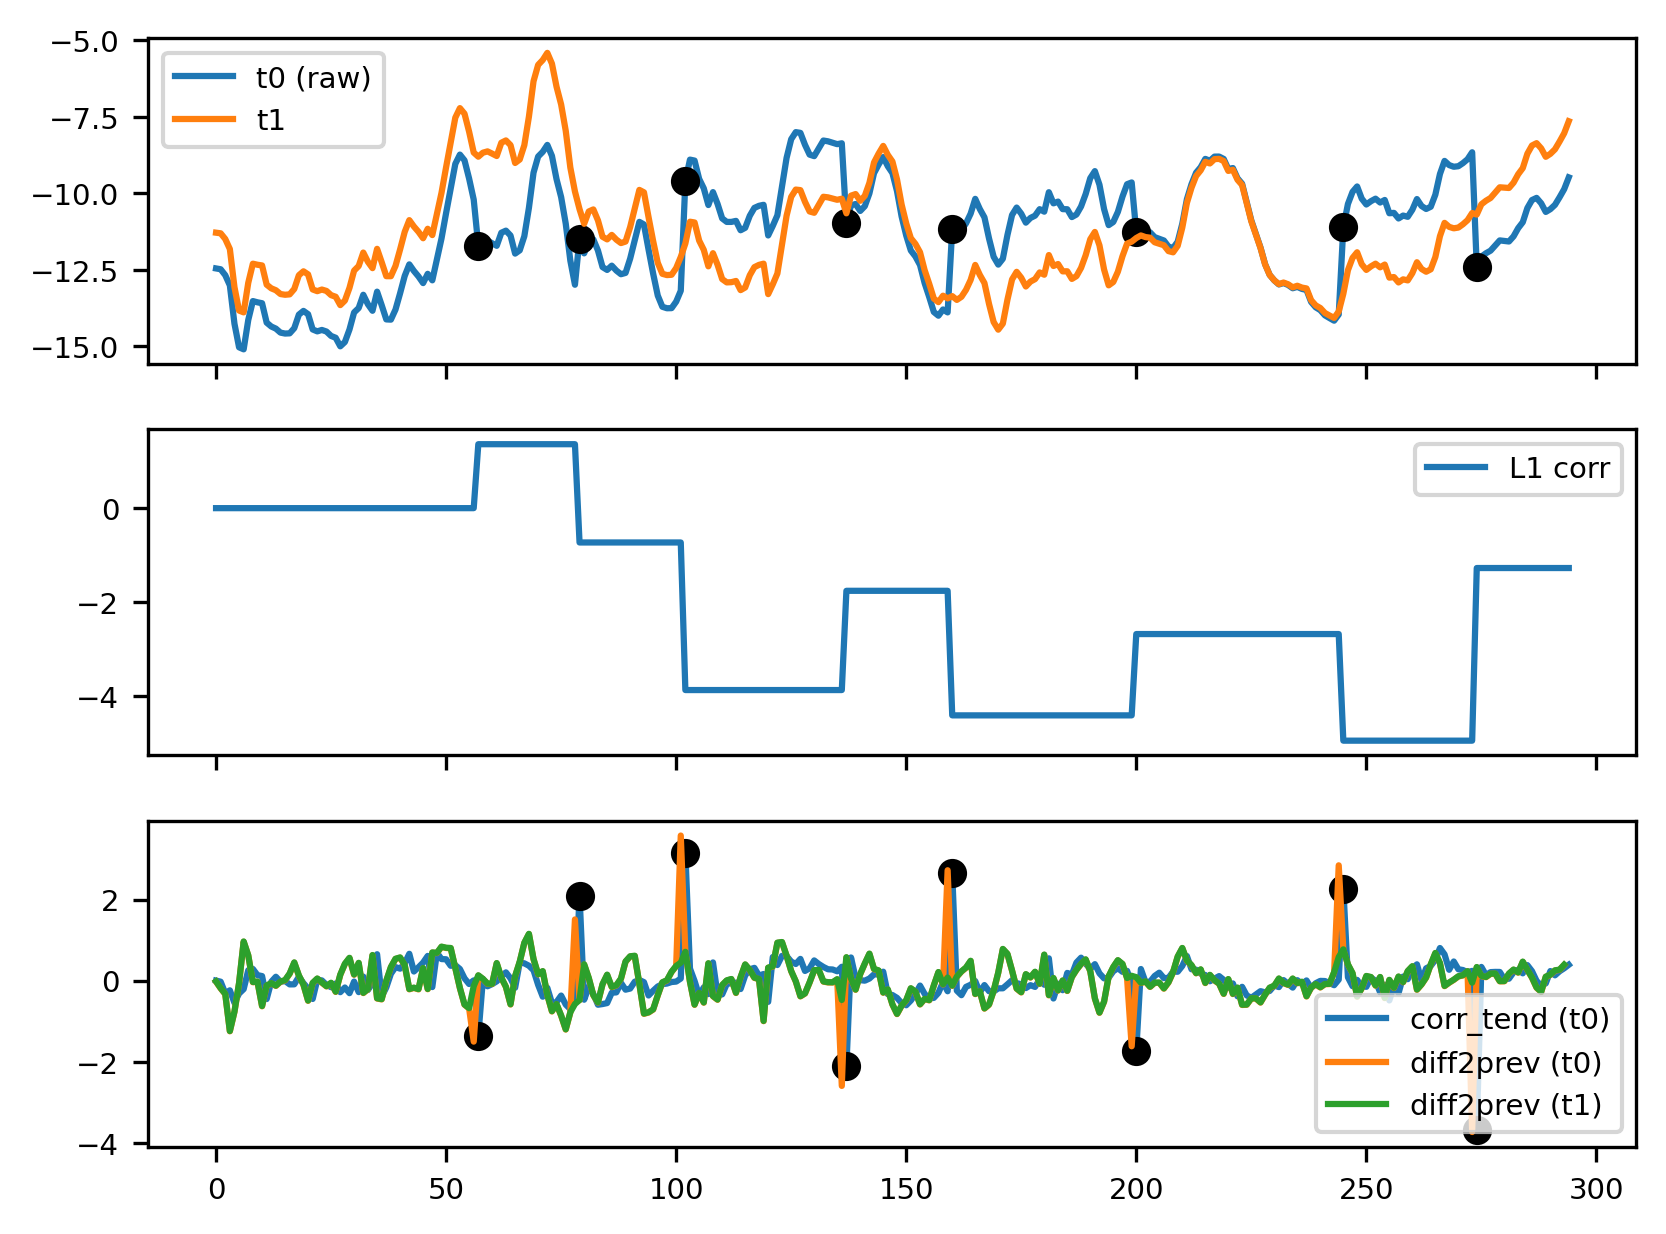

In [22]:
corr_tend = np.array([diff_matrix['raw'][i, i-1] if i > 0 else 0 for i in range (0, img_N)])

save_dir = pics_dir + '/corr/'
if not os.path.isdir (save_dir):
    os.mkdir (save_dir)

L1_corr, L1_diff2prev, outlier_ind = IR_processing_utils.sigma_tend_corr_multi (corr_tend)

img_array['t1'] = IR_processing_utils.apply_corr2array (img_array['raw'], L1_corr)
diff_matrix['t1'] = IR_processing_utils.apply_corr2diff_matrix (diff_matrix['raw'], L1_corr)


if corr_opts['detrend']:
    detrend_corr = IR_processing_utils.detrend_corr (img_array['t1'])
    img_array['t1'] = IR_processing_utils.apply_corr2array (img_array['t1'], detrend_corr)
    diff_matrix['t1'] = IR_processing_utils.apply_corr2diff_matrix (diff_matrix['t1'], detrend_corr)


mean_t0 = np.mean(np.mean(img_array['raw'], axis=0), axis=0)
mean_t1 = np.mean(np.mean(img_array['t1'], axis=0), axis=0)
t0_diff_mean = np.diff (mean_t0)
t1_diff_mean = np.diff (mean_t1)


fig, ax = plt.subplots(3,1, sharex = True)
ax[0].plot(mean_t0, label = 't0 (raw)')
ax[0].plot(outlier_ind, mean_t0[outlier_ind], 'ok')
ax[0].plot(mean_t1, label = 't1')
ax[0].legend()

ax[1].plot(L1_corr, label = 'L1 corr')
ax[1].legend()


ax[2].plot (corr_tend, label = 'corr_tend (t0)')
ax[2].plot (outlier_ind, corr_tend[outlier_ind], 'ok')
ax[2].plot(t0_diff_mean, label = 'diff2prev (t0)')
ax[2].plot(t1_diff_mean, label = 'diff2prev (t1)')
ax[2].legend()

plt.savefig(save_dir + 'L1_corr, detrend=' + str (corr_opts['detrend']) + '_new.png')


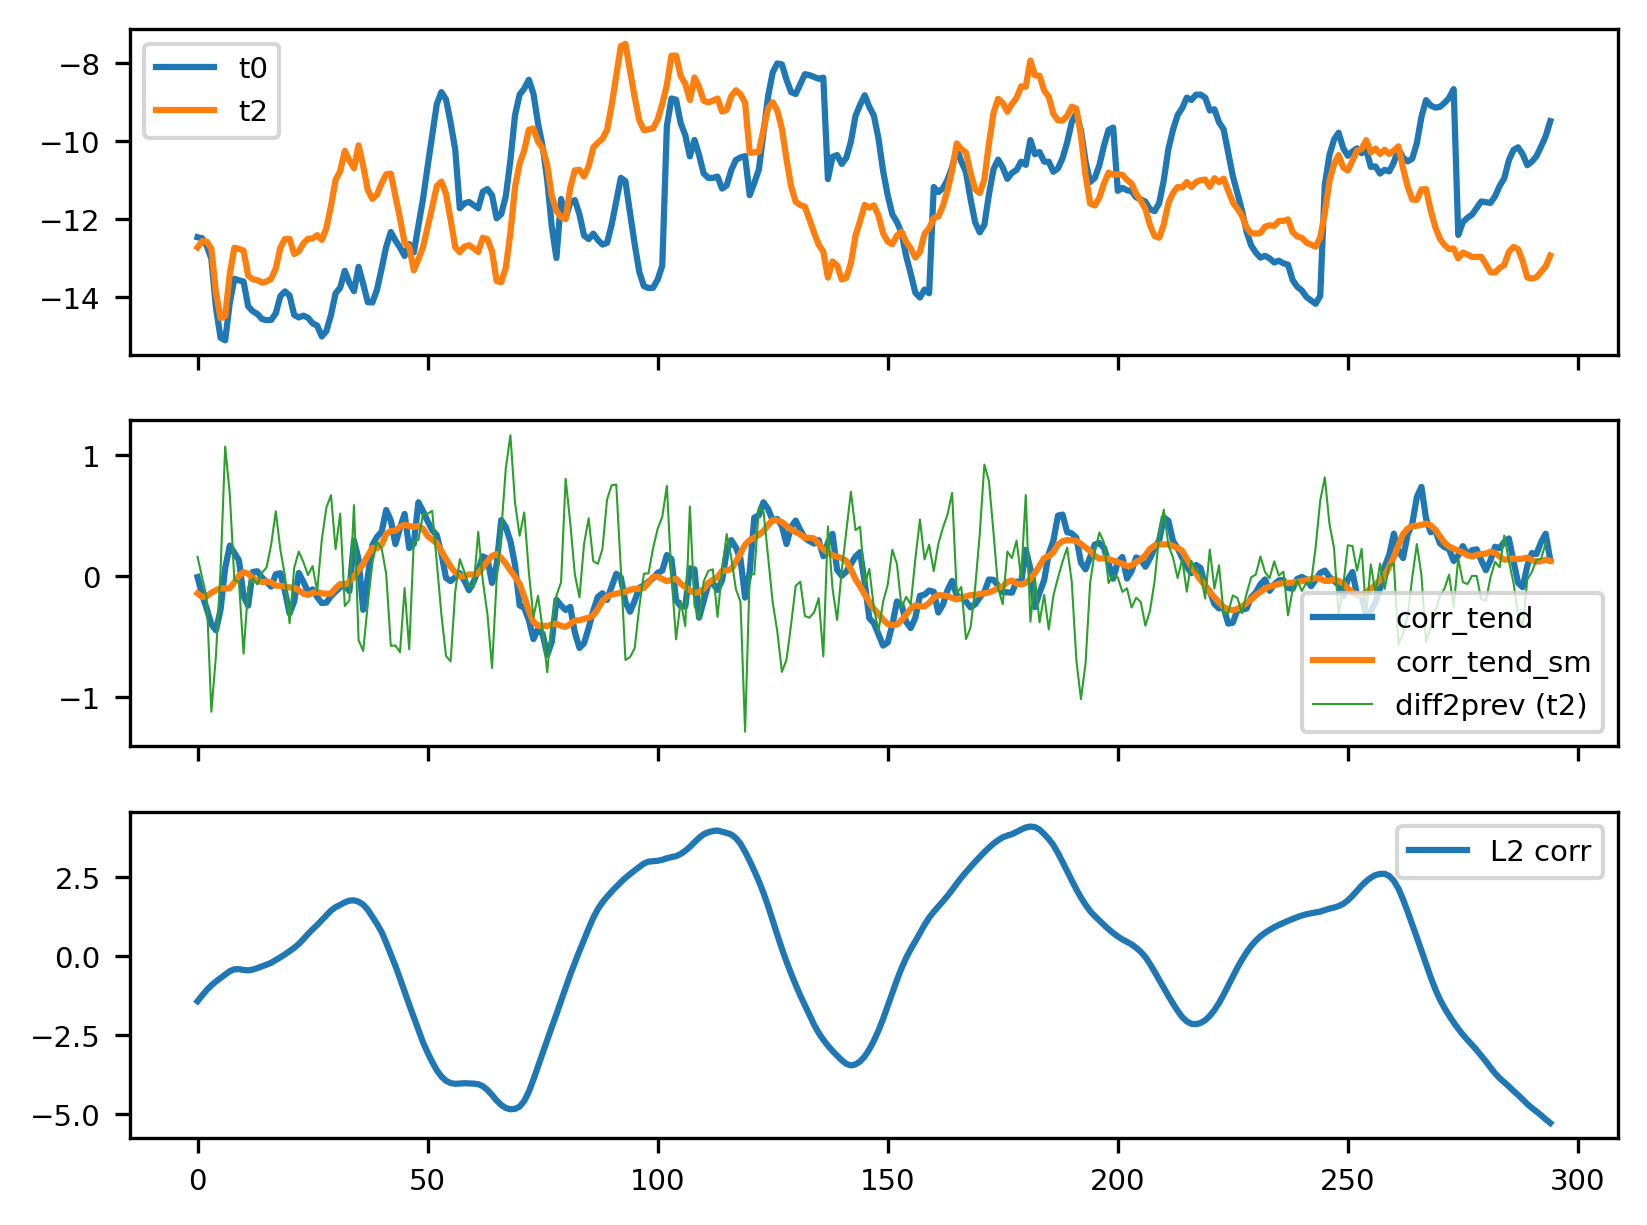

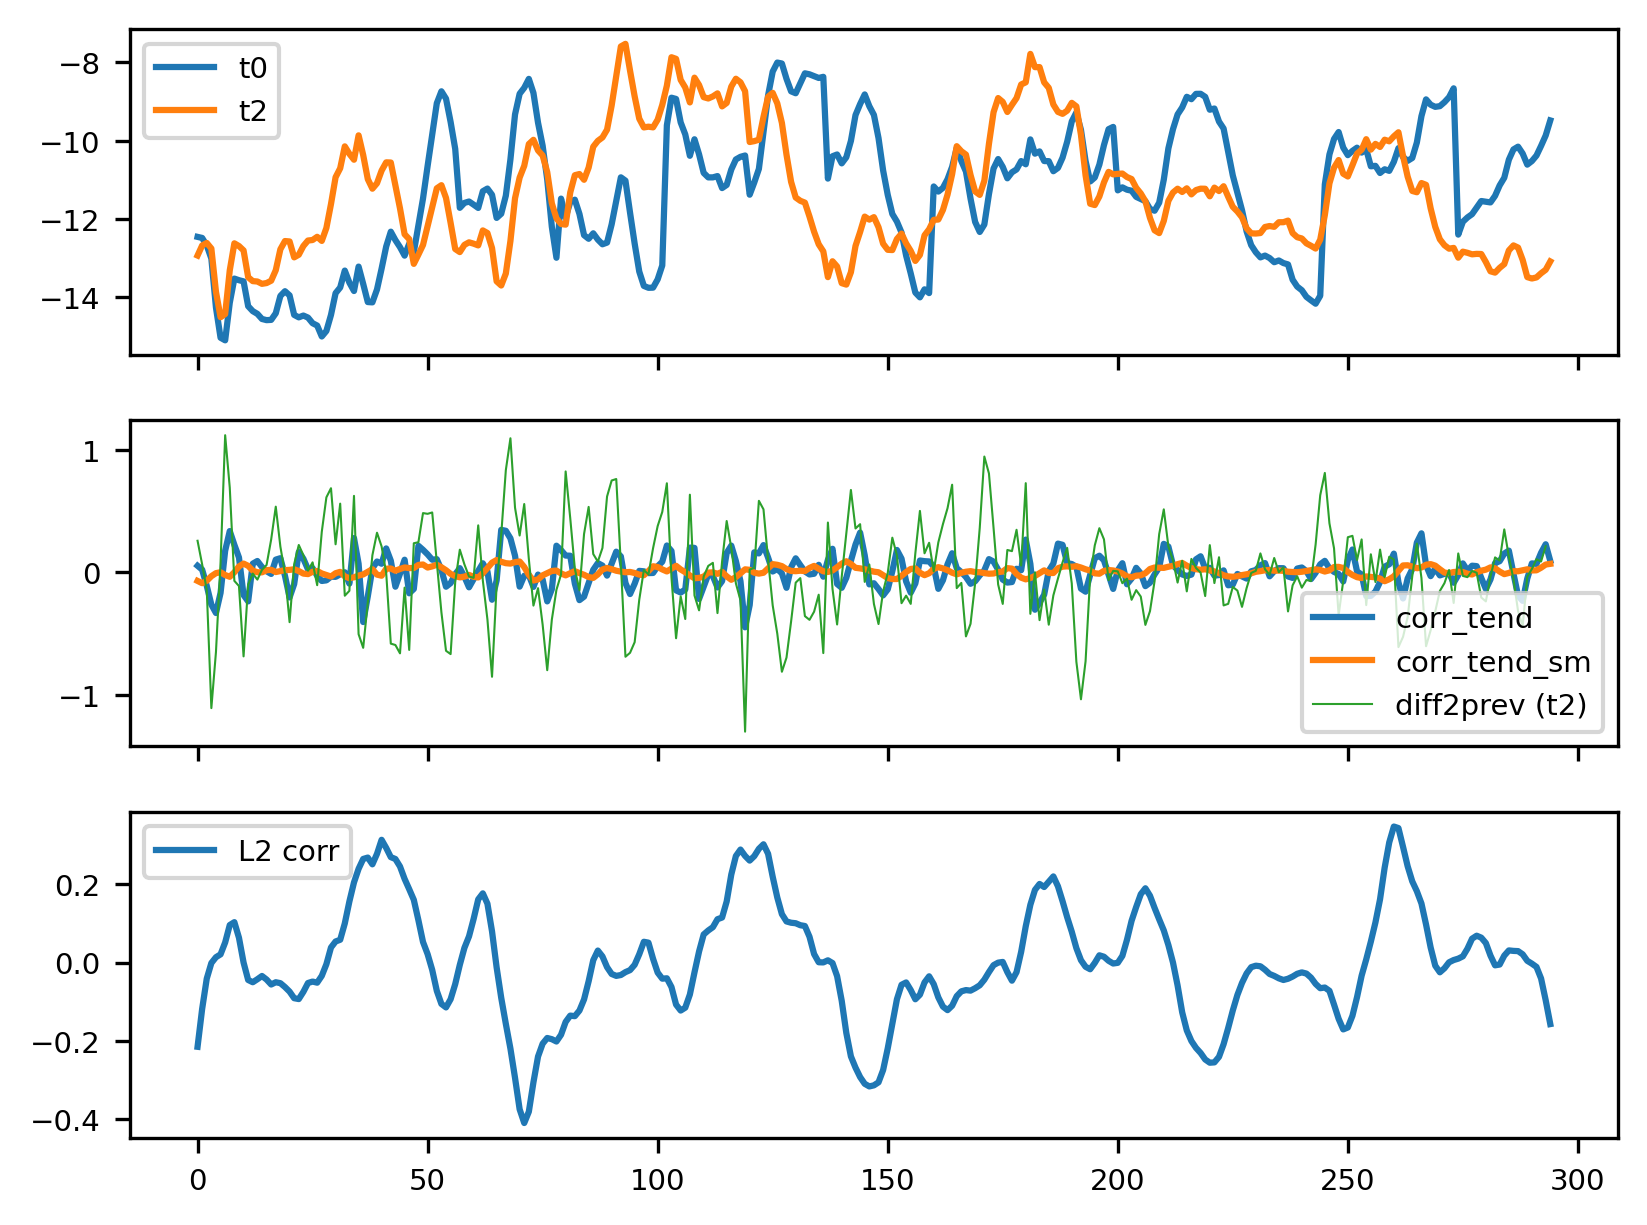

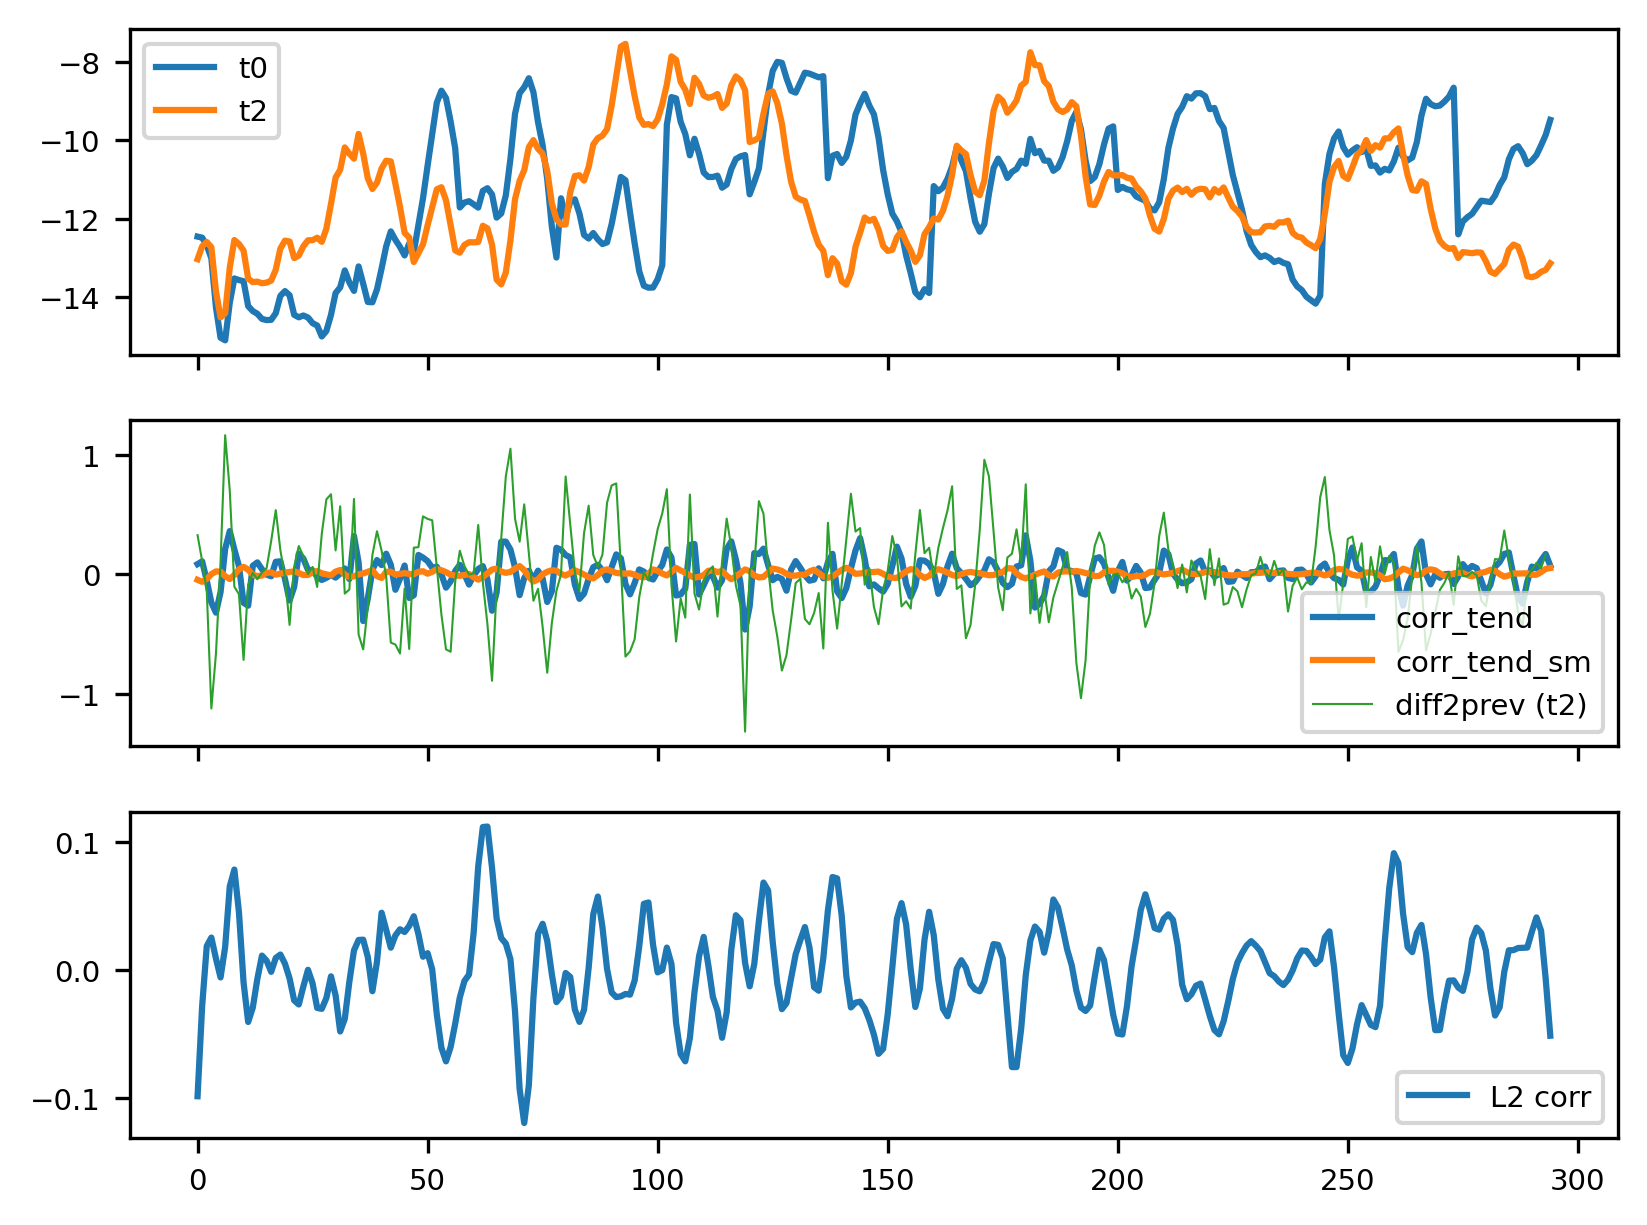

In [23]:
for step in range (0, 3):

    src = 't1' if step == 0 else 't2'
    
    corr_tend_c = np.array([diff_matrix[src][i+1, i-1] if (i > 0 and i < img_N - 1) else 0 for i in range (0, img_N)])
    corr_tend_l = np.array([diff_matrix[src][i+1, i]   if  i < img_N - 1 else 0 for i in range (0, img_N)])
    corr_tend_r = np.array([diff_matrix[src][i, i-1]   if  i > 0 else 0 for i in range (0, img_N)])

    corr_tend = (corr_tend_c / 2 + corr_tend_l + corr_tend_r) / 3
    corr_tend [np.isnan(corr_tend)] = 0

    N = corr_opts['L2_wnd']

    corr_tend_sm  =  np.convolve(corr_tend, np.ones(N)/N, mode='same')    


    L2_corr = -np.cumsum(corr_tend_sm)
    if corr_opts['detrend']:
        L2_corr = scipy.signal.detrend (L2_corr)

    img_array['t2'] = IR_processing_utils.apply_corr2array (img_array[src], L2_corr)
    diff_matrix['t2'] = IR_processing_utils.apply_corr2diff_matrix (diff_matrix[src], L2_corr)

    mean_t2 = np.mean(np.mean(img_array['t2'], axis=0), axis=0)
    t2_diff_mean = np.diff (mean_t2)

    fig, ax = plt.subplots(3,1, sharex = True)
    ax[0].plot(mean_t0, label = 't0')
    #ax[0].plot(mean_t1, label = 't1')
    ax[0].plot(mean_t2, label = 't2')
    ax[0].legend()

    ax[1].plot(corr_tend,    label = 'corr_tend')
    ax[1].plot(corr_tend_sm, label = 'corr_tend_sm')
    #ax[1].plot(t1_diff_mean, label = 'diff2prev (t1)', linewidth = 0.5)
    ax[1].plot(t2_diff_mean, label = 'diff2prev (t2)', linewidth = 0.5)
    ax[1].legend()

    #ax[2].plot(L1_corr, label = 'L1 corr')
    ax[2].plot(L2_corr, label = 'L2 corr')
    ax[2].legend()


    plt.savefig(save_dir + 'L2_corr, detrend=' + str (corr_opts['detrend']) + '_new' + str(step) + '.png')


100%|██████████| 295/295 [00:00<00:00, 3933.34it/s]


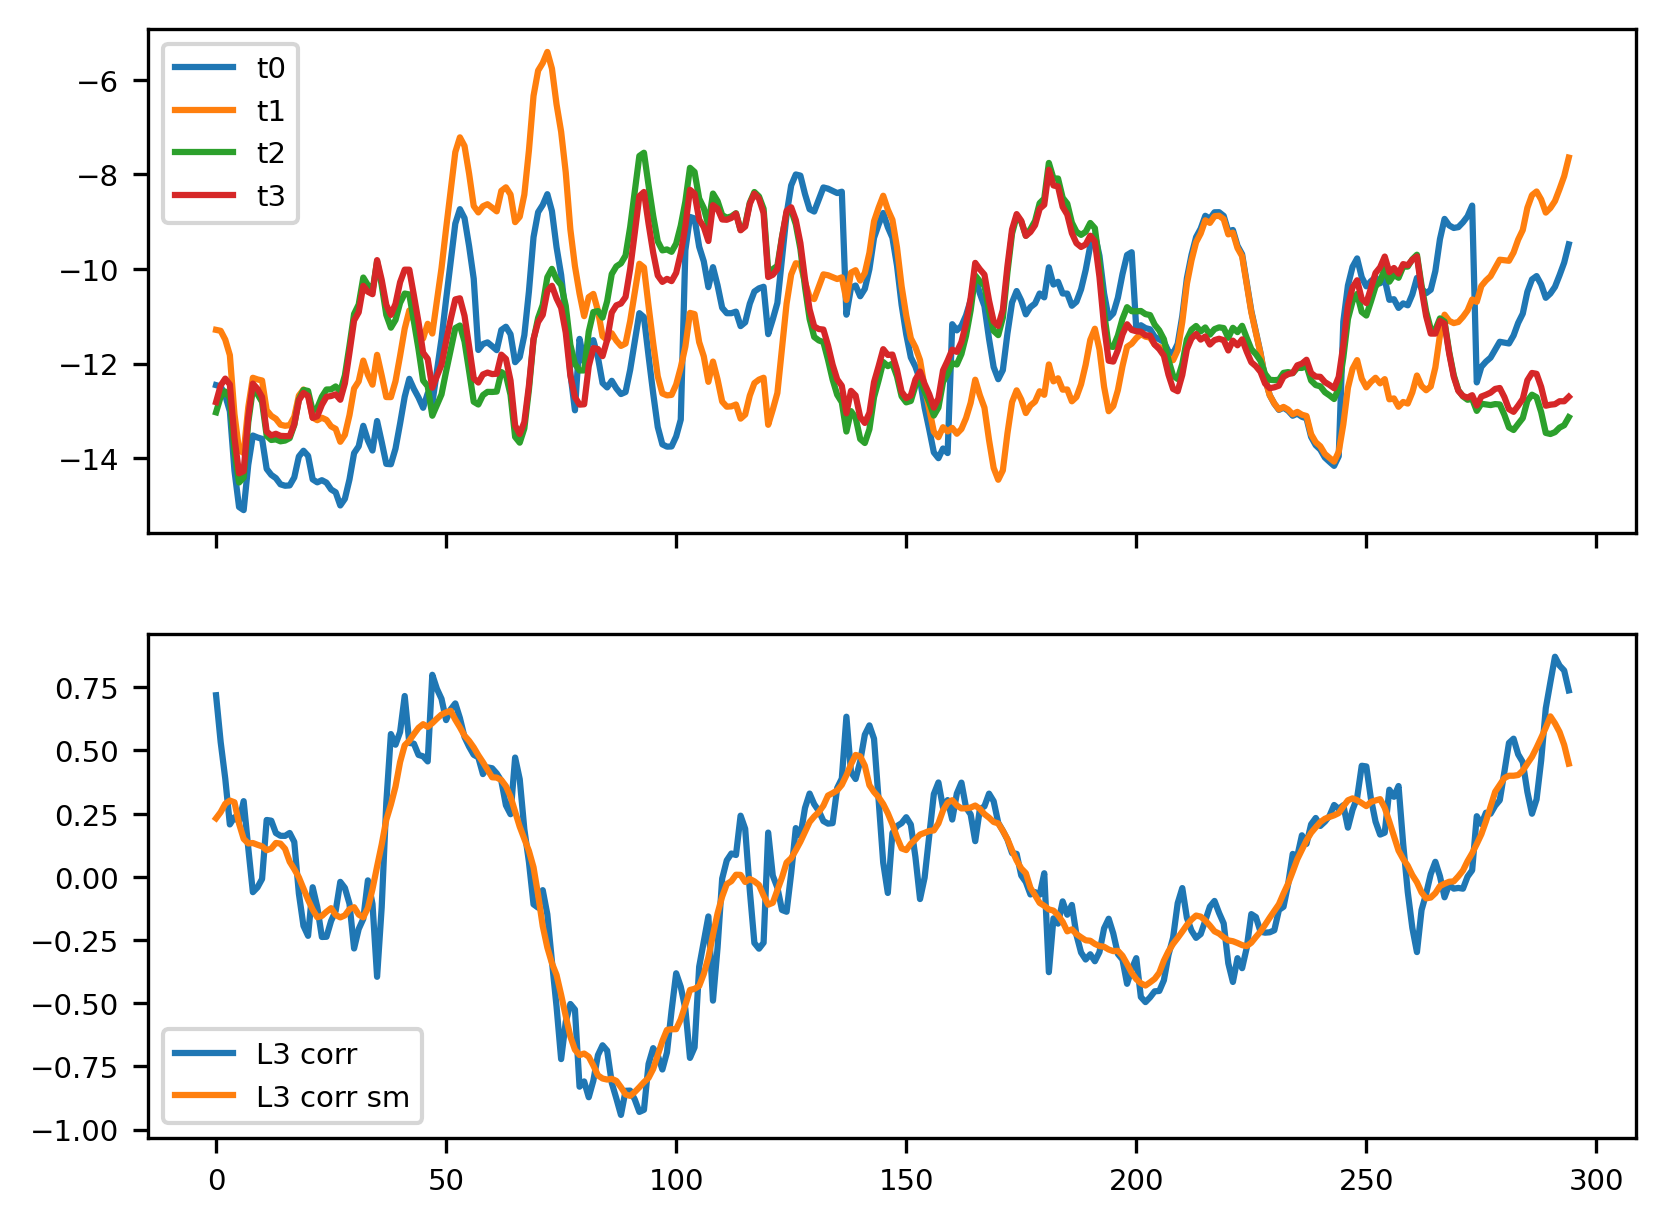

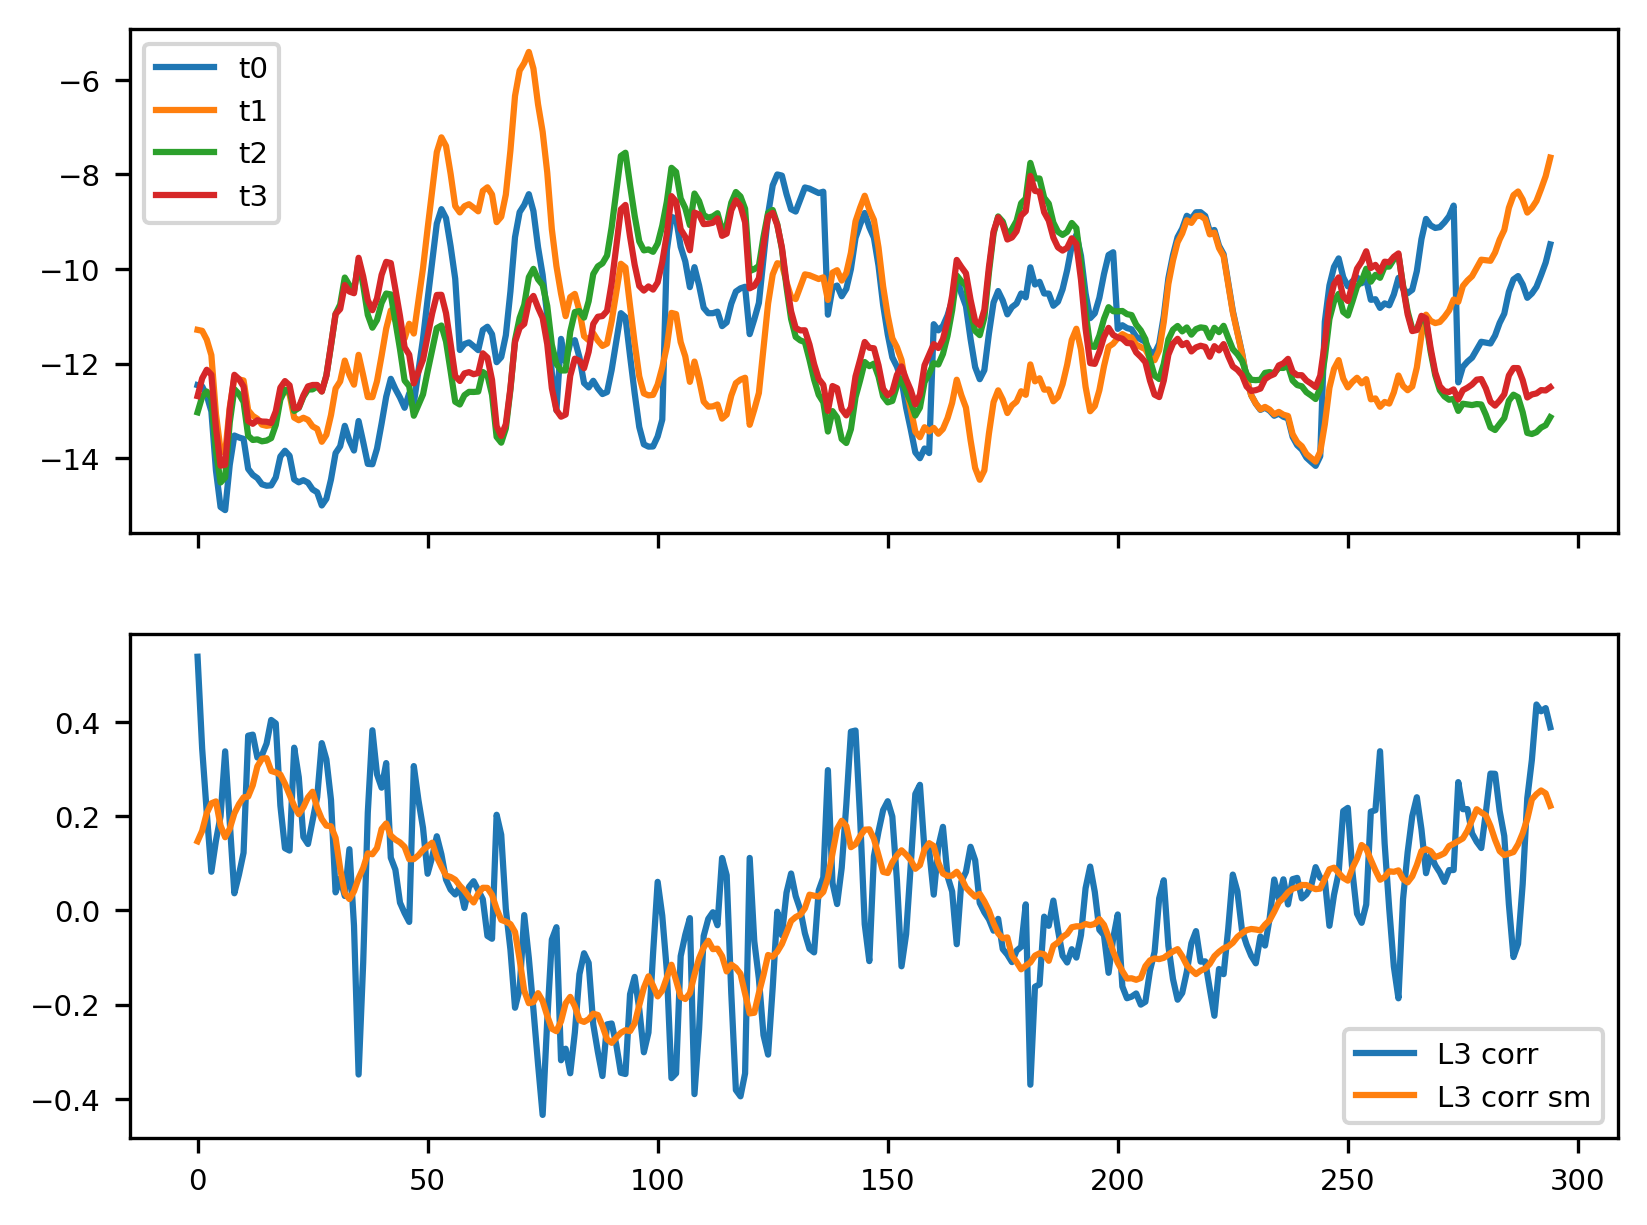

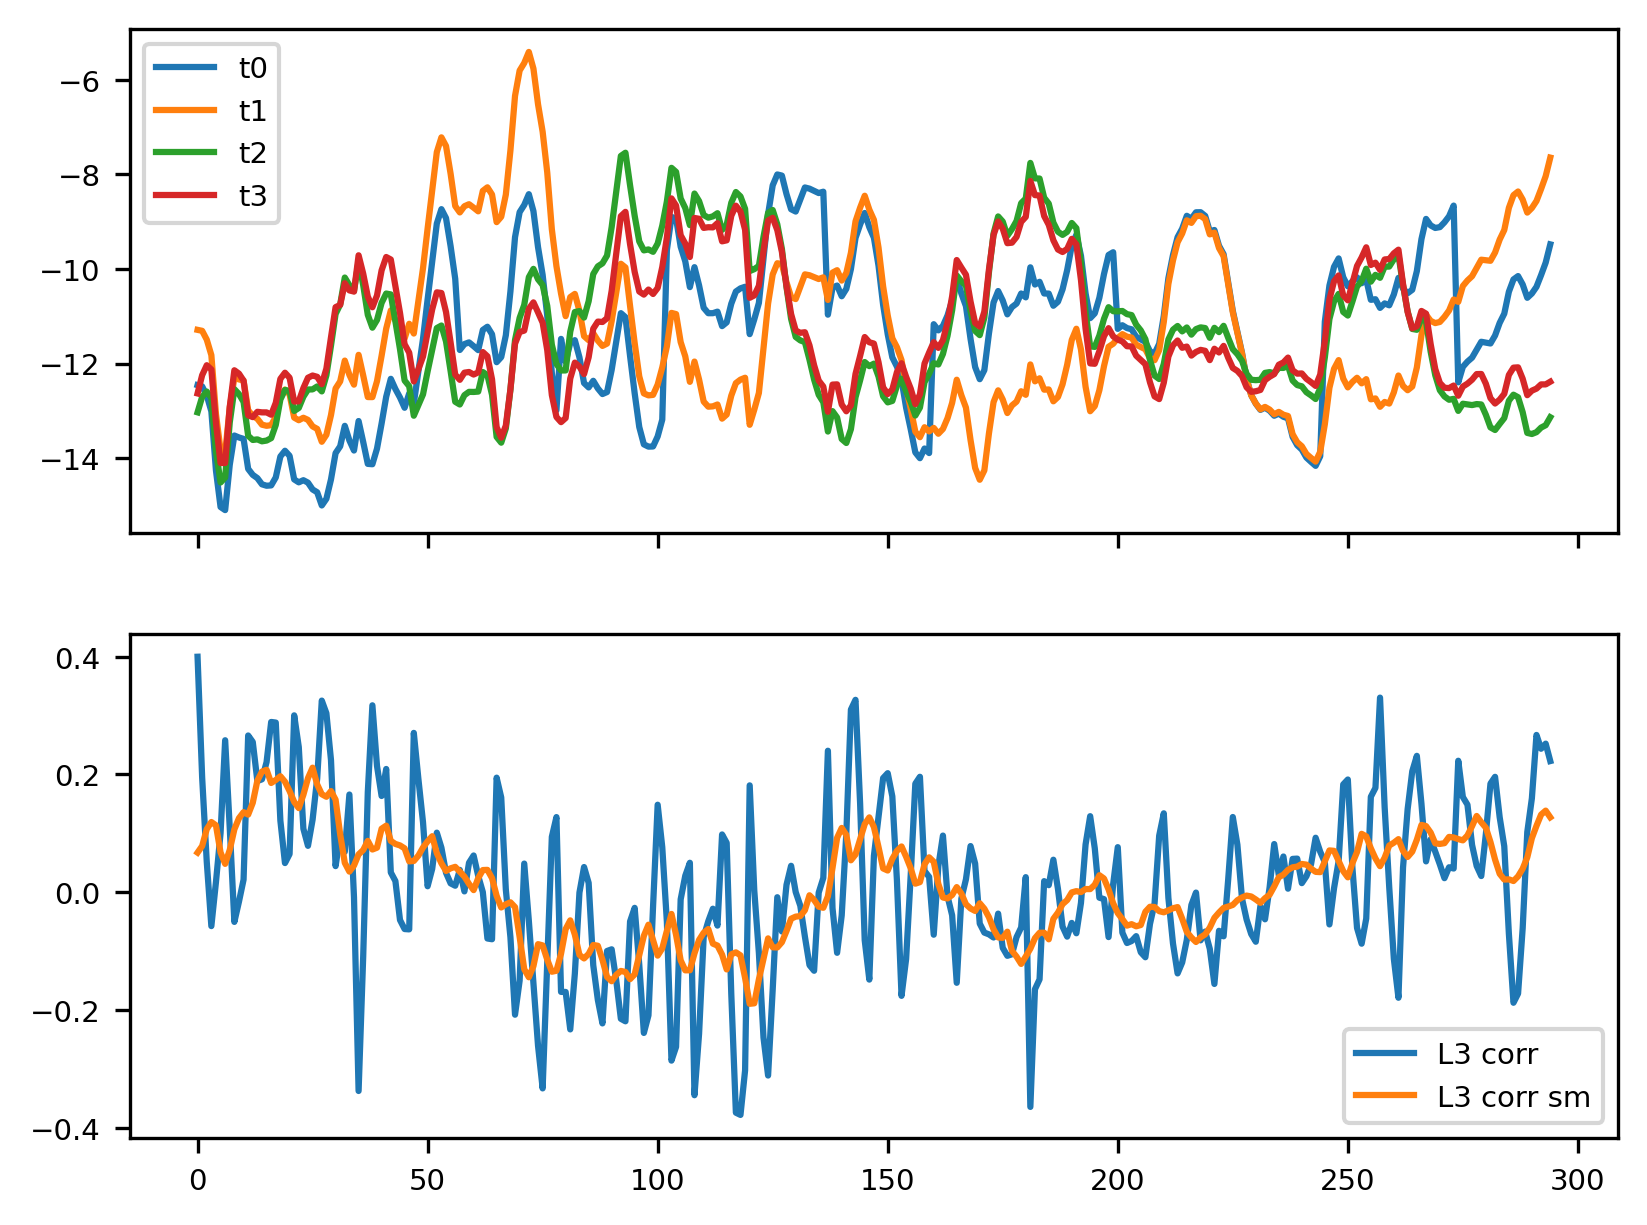

In [24]:
crd = np.arange(0, img_df.shape[0])

for step in range (0, 3):

    src_key = 't2' if step == 0 else 't3'

    L3_corr = np.zeros_like(img_df['gps_lon'])

    for i in tqdm (range (0, img_df.shape[0])):

        diff_line = diff_matrix[src_key][i, :]
        weight_line = diff_weights[i, :]

        ind2sel = np.where(~np.isnan(diff_line))[0]

        gps_az_diff = img_df['gps_azimuth'] - img_df['gps_azimuth'][i]
        gps_az_diff = np.mod (np.abs(gps_az_diff), 360)

        # display(img_df['gps_azimuth'][idx2test])
        # display(img_df['gps_azimuth'][idx2test-1])
        # display(gps_az_diff[idx2test-1])
        # display(np.abs(np.mod (gps_az_diff[idx2test-1], 360)))

        ind2sel_az =  np.where(~np.isnan(diff_line) & (gps_az_diff > 45))[0]

        #L3_corr[i] = -np.mean(diff_line[ind2sel_az])/2
        L3_corr[i] = -0.5 * np.sum(diff_line[ind2sel_az] * weight_line[ind2sel_az]) / np.sum(weight_line[ind2sel_az])



        if np.isnan(L3_corr[i]):
            idx2test = i

            display (mean_t2[idx2test])
            display (mean_t2[ind2sel_az])
            display (corr_line[ind2sel_az])

            ind2draw = slice (np.min(ind2sel), np.max(ind2sel))
            plt.figure()
            plt.scatter(img_df['gps_lon'], img_df['gps_lat'], 25, mean_t2, edgecolor = 'white')
            plt.scatter(img_df['gps_lon'][ind2draw], img_df['gps_lat'][ind2draw], 25, mean_t2[ind2draw], edgecolor = 'gray')
            plt.scatter(img_df['gps_lon'][ind2sel], img_df['gps_lat'][ind2sel], 25, mean_t2[ind2sel], edgecolor = 'black')
            plt.scatter(img_df['gps_lon'][ind2sel_az], img_df['gps_lat'][ind2sel_az], 25, mean_t2[ind2sel_az], 's', edgecolor = 'black')

            plt.scatter(img_df['gps_lon'][idx2test], img_df['gps_lat'][idx2test], 25, mean_t2[idx2test], edgecolor = 'red')


            plt.figure()
            plt.pcolormesh(crd[ind2draw], crd[ind2draw], corr_matrix[ind2draw, ind2draw], cmap='seismic')


            plt.plot(crd[idx2test], crd[idx2test], 'sr', markerfacecolor="None")
            for i in ind2sel_az:
                plt.plot(crd[idx2test], crd[i], 'sk', markerfacecolor="None", markersize = 2)
                plt.plot(crd[i], crd[idx2test], 'sk', markerfacecolor="None", markersize = 2)

            plt.figure()
            plt.plot(crd[ind2sel], test_line[ind2sel], 'o')
            break

    L3_corr_sm = np.convolve(L3_corr, np.ones(corr_opts['L3_wnd'])/corr_opts['L3_wnd'], mode='same')   

    img_array['t3'] = IR_processing_utils.apply_corr2array(img_array[src_key], L3_corr_sm)
    diff_matrix['t3'] =  IR_processing_utils.apply_corr2diff_matrix(diff_matrix[src_key], L3_corr_sm)

    mean_t3 = np.mean(np.mean(img_array['t3'], axis=0), axis=0)


    fig, ax = plt.subplots(2,1, sharex = True)
    ax[0].plot(mean_t0, label = 't0')
    ax[0].plot(mean_t1, label = 't1')
    ax[0].plot(mean_t2, label = 't2')
    ax[0].plot(mean_t3, label = 't3')
    ax[0].legend()

    ax[1].plot(L3_corr, label = 'L3 corr')
    ax[1].plot(L3_corr_sm, label = 'L3 corr sm')
    ax[1].legend()

    plt.savefig(save_dir + 'L3_corr, detrend=' + str (corr_opts['detrend']) + '_new' + str (step) + '.png')



SystemExit: 

c:\Anaconda\envs\GIS\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


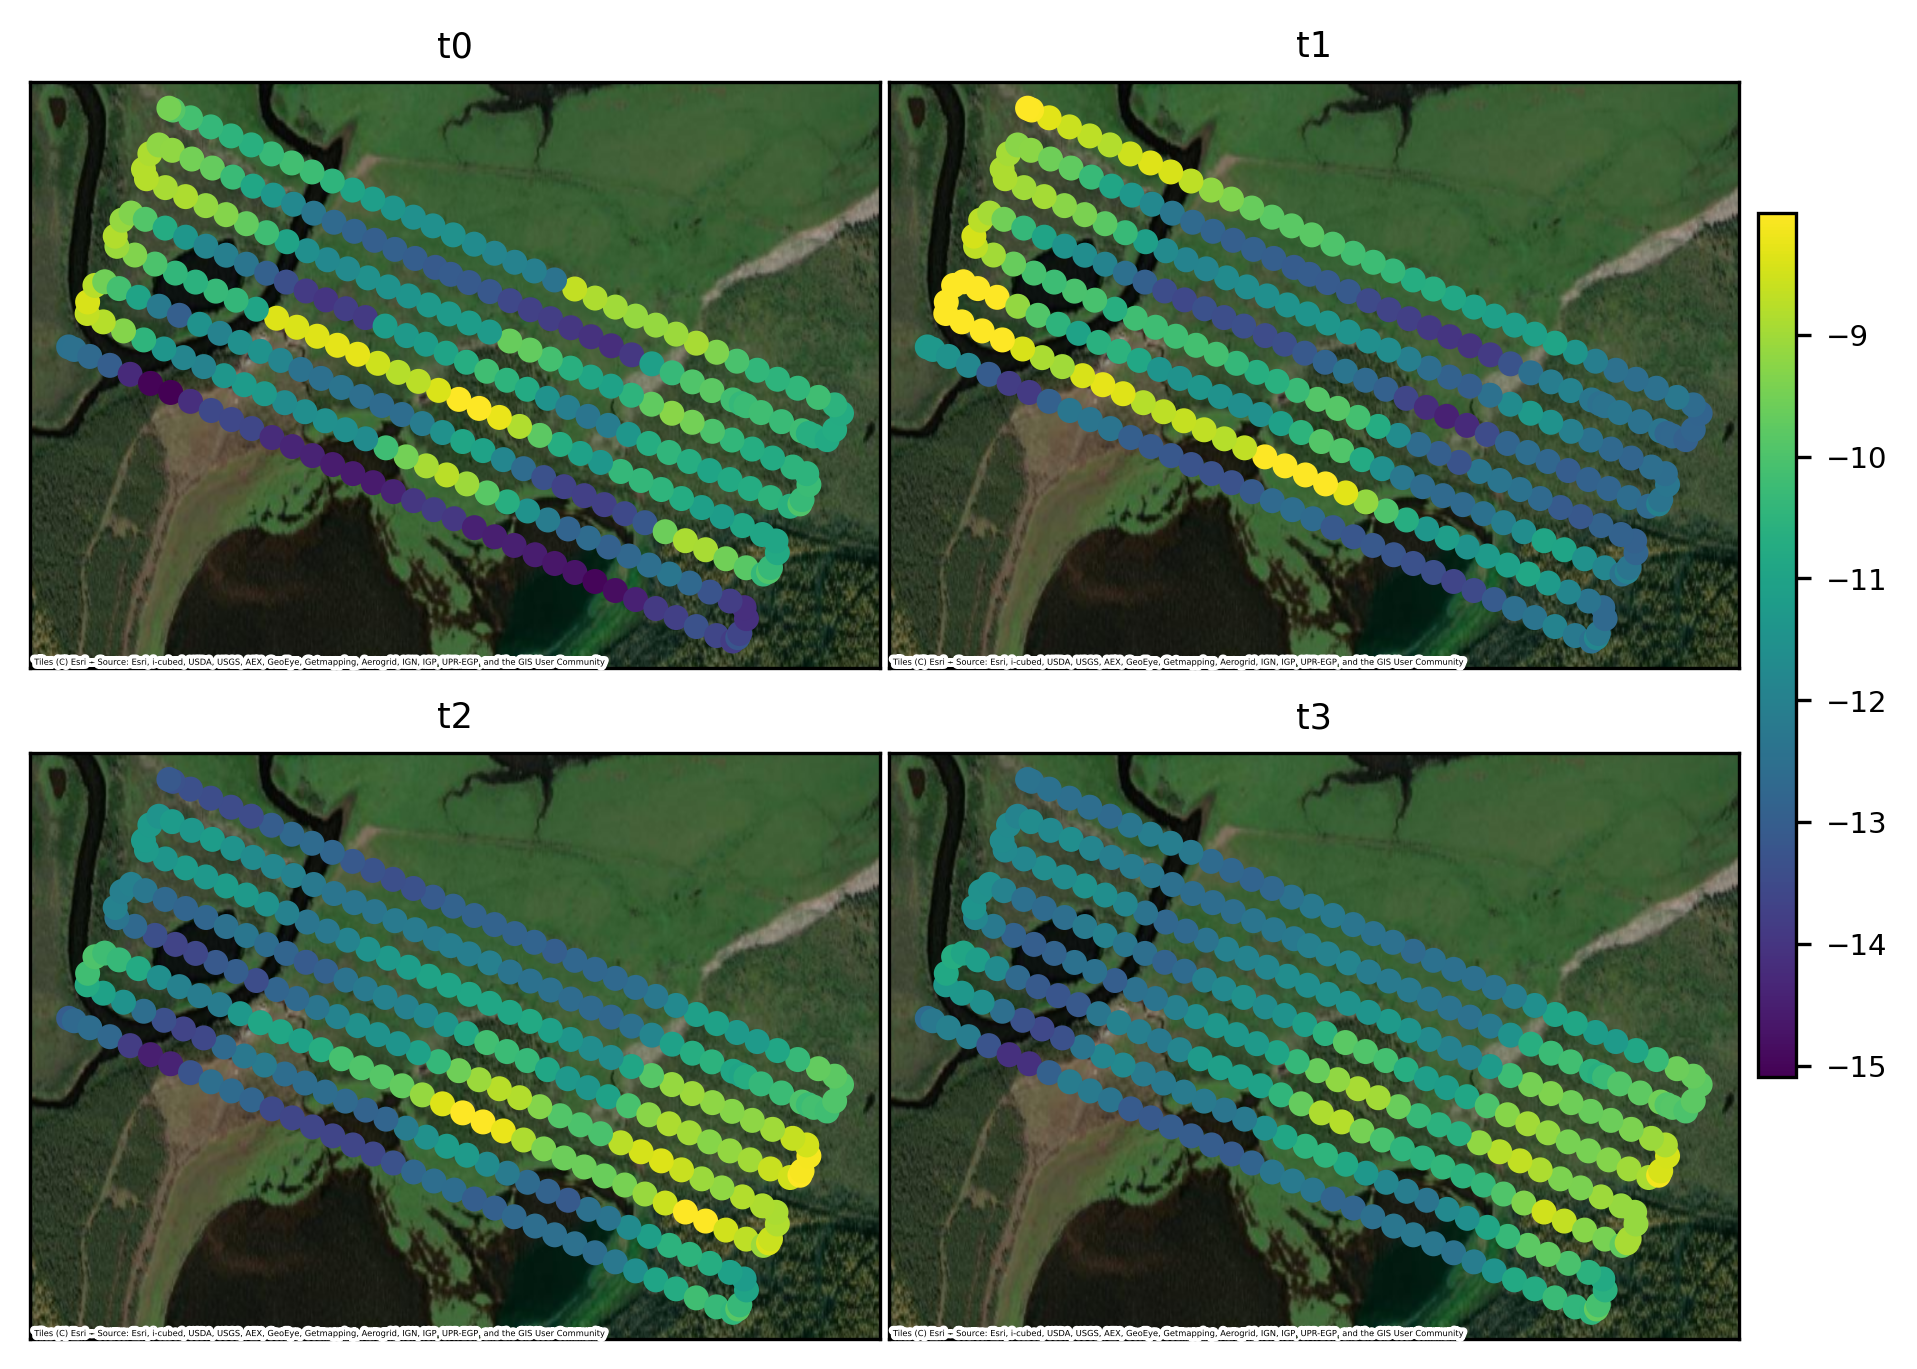

In [25]:

fig, ax = plt.subplots(2,2) #, figsize=(10,5))
ax = ax.flatten()


im = ax[0].scatter(img_df['gps_lon'], img_df['gps_lat'], 25, mean_t0, vmin = mean_t0.min(), vmax = mean_t0.max())
ax[1].scatter(img_df['gps_lon'], img_df['gps_lat'], 25, mean_t1, vmin = mean_t0.min(), vmax = mean_t0.max())
ax[2].scatter(img_df['gps_lon'], img_df['gps_lat'], 25, mean_t2, vmin = mean_t0.min(), vmax = mean_t0.max())
ax[3].scatter(img_df['gps_lon'], img_df['gps_lat'], 25, mean_t3, vmin = mean_t0.min(), vmax = mean_t0.max())


for i, a in enumerate (ax):
    cx.add_basemap(a, source = cx.providers.Esri.WorldImagery, crs = 4326, attribution_size = 2)    
    a.set_xticks([])
    a.set_yticks([])
    a.set_aspect(1.0/np.cos(img_df['gps_lat'].mean()*np.pi/180))
    a.set_title ('t' + str(i))

plt.subplots_adjust(left=0.01, bottom=0.01, right=0.9, top=0.9, wspace=0.01, hspace=0.1)

cbar_ax = fig.add_axes([0.91, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax)

plt.savefig(save_dir + 'all_corr, detrend=' + str (corr_opts['detrend']) + '_new2.png')

sys.exit()

In [ ]:
for key in img_array.keys():
    if key == 'raw':
        continue
    if key != 't3':
        continue


    out_dir = data_dir + '\\' + key + 'dt' if corr_opts['detrend'] else 'nodt'
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)

    IR_processing_utils.write_IR_images (img_array[key], img_df, out_dir, data_dir, n_jobs = 8)



100%|██████████| 524/524 [03:44<00:00,  2.33it/s]


In [ ]:
save_dir = pics_dir + '/corr/'
if not os.path.isdir (save_dir):
    os.mkdir (save_dir)

mean_t0 = np.mean(np.mean(img_array['raw'], axis=0), axis=0)

for step in range (0, 50):

    src_key = 'raw' if step == 0 else 't4'

    L4_corr = np.zeros_like(img_df['gps_lon'])

    for i in tqdm (range (0, img_df.shape[0])):

        diff_line = diff_matrix[src_key][i, :]
        weight_line = diff_weights[i, :]

        ind2sel = np.where(~np.isnan(diff_line))[0]

        #L3_corr[i] = -np.mean(diff_line[ind2sel_az])/2
        L4_corr[i] = -0.25 * np.sum(diff_line[ind2sel] * weight_line[ind2sel]) / np.sum(weight_line[ind2sel])

    img_array['t4'] = IR_processing_utils.apply_corr2array(img_array[src_key], L4_corr)
    diff_matrix['t4'] =  IR_processing_utils.apply_corr2diff_matrix(diff_matrix[src_key], L4_corr)

    if np.mod (step, 10) == 0:
        tend2prev = np.array([diff_matrix['t4'][i, i-1] if i > 0 else 0 for i in range (0, img_N)])
        mean_t4 = np.mean(np.mean(img_array['t4'], axis=0), axis=0)

        
        fig, ax = plt.subplots(2,2, figsize = (10, 5))

        ax = ax.flatten()
        ax[0].scatter(img_df['gps_lon'], img_df['gps_lat'], 25, mean_t4)


        cx.add_basemap(ax[0], source = cx.providers.Esri.WorldImagery, crs = 4326, attribution_size = 2)    
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_aspect(1.0/np.cos(img_df['gps_lat'].mean()*np.pi/180))
        
        ax[1].plot(mean_t0)
        ax[1].plot(mean_t4)

        ax[3].plot (tend2prev)
        
        plt.savefig(save_dir + 'L4_corr, detrend=' + str (corr_opts['detrend']) + '_step' + str(step) + '.png')
    #break



